In [ ]:
import matplotlib.pyplot as plt
import warnings

plt.style.use('seaborn')
# plt.style.use('seaborn-colorblind') #alternative
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# 1. 기하 브라운 운동을 사용한 주가 역학 시뮬레이션

**1. 몬테카를로 시뮬레이션**
 - 무작위한 변수를 계산식, 모델에 반복적으로 투입하고, 투입 집합에서 무작위한 샘플링을 진행한 후 결과값 도출
 - 수백번, 수천번 시행 후 결과의 평균을 내어 추정값 결정
 



**2. 몬테카를로 시뮬레이션 혹은 기하 브라운 운동 기반 예측을 하는 이유?**
 - **상품 개발 및 가격 책정** : ELS, ELF, ELD 등 상품 개발 시 개발 금융사의 수익 시뮬레이션
 
 - 포트폴리오 불확실성 추정 : 펀드 포트폴리오에 대한 최대 예상 손실액, 예상 부족액 계산
 - 채권 평가 : 채권 미래 가격 예측 등

**3. 기하브라운운동 기반 주가 모형 식 설명**



S : 주가

μ : 드리프트 계수, 확정 수익률

σ : 디퓨젼 계수, 변동성

Wt : 브라운 운동, 웨그너 계수

**한달 이후의 마이크로소프트 주가를 시뮬레이션해보자**

In [ ]:
import numpy as np
import pandas as pd
!pip install yfinance
import yfinance as yf
RISKY_ASSET = 'MSFT'
START_DATE = '2019-01-01'
END_DATE = '2019-07-31'

     |████████████████████████████████| 63 kB 1.6 MB/s 
     |████████████████████████████████| 6.4 MB 16.4 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
df = yf.download(RISKY_ASSET, start=START_DATE, 
                 end=END_DATE, adjusted=True)
print(f'Downloaded {df.shape[0]} rows of data.')

[*********************100%***********************]  1 of 1 completed
Downloaded 145 rows of data.


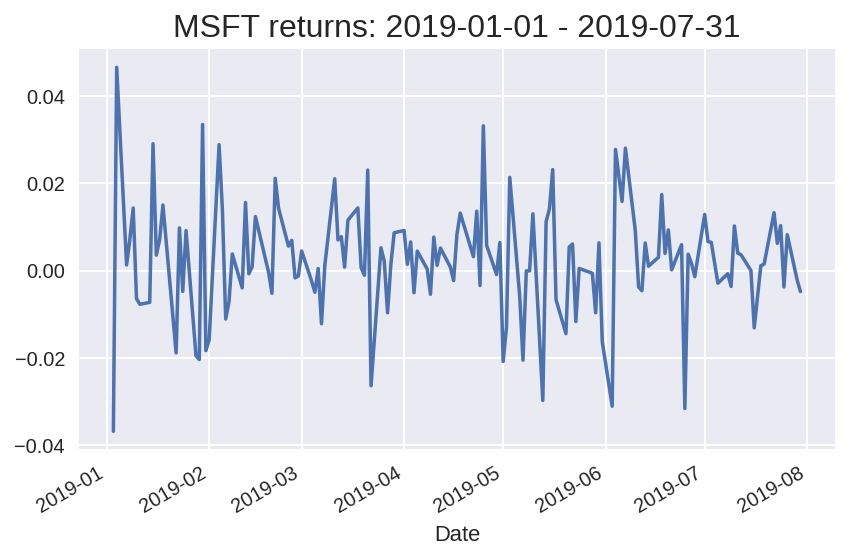

Average return: 0.24%


In [ ]:
#일수익률 계산하기
adj_close = df['Adj Close']
returns = adj_close.pct_change().dropna()

ax = returns.plot()
ax.set_title(f'{RISKY_ASSET} returns: {START_DATE} - {END_DATE}', 
             fontsize=16)

plt.tight_layout()
plt.show()

print(f'Average return: {100 * returns.mean():.2f}%')

In [ ]:
#데이터를 훈련과 테스트 집합으로 분할한다
train = returns['2019-01-01':'2019-06-30']
test = returns['2019-07-01':'2019-07-31']

In [ ]:
#시뮬레이션 매개변수 설정
T = len(test) #예측기간 (테스트 집합 기간)
N = len(test) #예상 기간에서의 시간 증분 수, 그러니까 매일마다 예측하기 위해 기간을 이 증분수로 나눈다
S_0 = adj_close[train.index[-1]] #최초 단가
N_SIM = 100 #시뮬레이션된 경로 수 실제 사례에서는 100보다 더 많은 샘플 경로를 사용한다
mu = train.mean() #μ: 드리프트 계수, 평균을 취한다
sigma = train.std() #σ : 디퓨전 계수, 표준편차를 취한다

In [ ]:
#시뮬레이션 함수 정의
def simulate_gbm(s_0, mu, sigma, n_sims, T, N, 
                 random_seed=42):
    '''
    Function used for simulating stock returns using Geometric Brownian Motion.
    
    Parameters
    ------------
    s_0 : float
        Initial stock price
    mu : float
        Drift coefficient
    sigma : float
        Diffusion coefficient
    n_sims : int
        Number of simulations paths
    dt : float
        Time increment, most commonly a day
    T : float
        Length of the forecast horizon, same unit as dt
    N : int
        Number of time increments in the forecast horizon
    random_seed : int
        Random seed for reproducibility

    Returns
    -----------
    S_t : np.ndarray
        Matrix (size: n_sims x (T+1)) containing the simulation results. 
        Rows respresent sample paths, while columns point of time.
    '''
    np.random.seed(random_seed)
    
    dt = T/N #시간증분 정의
    dW = np.random.normal(scale = np.sqrt(dt), size=(n_sims, N)) #브라운 증분 정의, scale : 분포의 표준편차
    W = np.cumsum(dW, axis=1) #브라운 증분의 누적합 계산 → 브라운 증분만의 경로
    
    time_step = np.linspace(dt, T, N) #dt에서 T까지 N개로 나눈 간격만큼의 1차원 행렬 만들기 (dt, 2dt, 3dt, ~~~, T)
    time_steps = np.broadcast_to(time_step, (n_sims, N)) #timestep 행렬을 (n_sims, N) shape로 깔아버리기
    
    S_t = s_0 * np.exp((mu - 0.5 * sigma**2) * time_steps 
                       + sigma * W) #기하브라운운동의 주가 모형 식 계산하기
    S_t = np.insert(S_t, 0, s_0, axis=1) #초기값 삽입
    
    return S_t

In [ ]:
#시뮬레이션 실행
gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N)

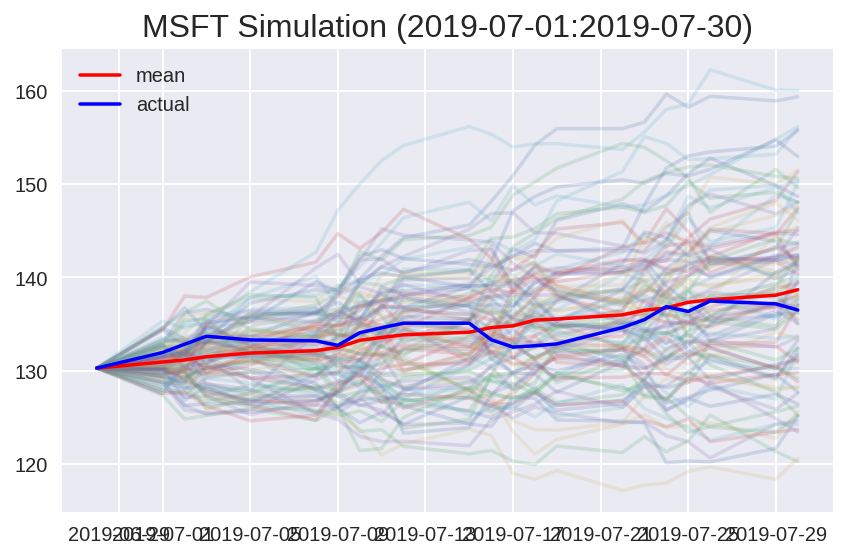

In [ ]:
#그래프 가즈아
# prepare objects for plotting 
last_train_date = train.index[-1].date()
first_test_date = test.index[0].date()
last_test_date = test.index[-1].date()
plot_title = (f'{RISKY_ASSET} Simulation '
              f'({first_test_date}:{last_test_date})')

selected_indices = adj_close[last_train_date:last_test_date].index
index = [date.date() for date in selected_indices]

gbm_simulations_df = pd.DataFrame(np.transpose(gbm_simulations), 
                                  index=index) #DataFrame으로 변환 + 열 별로 하나의 값을 갖도록 전치 수행

# plotting
ax = gbm_simulations_df.plot(alpha=0.2, legend=False) #선을 투명하게 만들기 위해 alpha 0.2 집어놓기
line_1, = ax.plot(index, gbm_simulations_df.mean(axis=1), 
                  color='red')
line_2, = ax.plot(index, adj_close[last_train_date:last_test_date], 
                  color='blue')
ax.set_title(plot_title, fontsize=16)
ax.legend((line_1, line_2), ('mean', 'actual'))

plt.tight_layout()
plt.show()
#시뮬레이션의 평균 값이 양의 드리프트 항에 의해 양의 경향을 보인다

**※ 추가사항 : 대조변수법 (Antithetic Variate)**
 - 적은 계산으로도 정확도가 높은 추정치를 얻는 시뮬레이션 방법
 - 변수 X를 계산하는데 사용했던 난수를 X'를 계산하는 데 또 사용한다
 - 랜덤 추출한 값에다가 일부러 음의 종속성을 도입해서 대조값을 만든다
 - 사용 효과1 : 표준 정규 표본 개수를 반으로 줄일 수 있다 (반만 만들면 나머지 반은 자동 생성되므로)
 - 사용 효과2: 표본 경로 분산을 감소시키고 정확도도 개선된다

 ▶ 이외에도 공통난수법, 제어변수법, 층별 표본추출법, 중요부 표본추출법 등 여러가지가 있음

In [ ]:
#이전 버전 함수에서 소요되었던 시간은?
%timeit gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N)

The slowest run took 5.09 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 5: 246 µs per loop


In [ ]:
#대조변수법을 활용한 함수 만들기
def simulate_gbm(s_0, mu, sigma, n_sims, T, N, random_seed=42, antithetic_var=False):
    '''
    Function used for simulating stock returns using Geometric Brownian Motion.
    
    Parameters
    ------------
    s_0 : float
        Initial stock price
    mu : float
        Drift coefficient
    sigma : float
        Diffusion coefficient
    n_sims : int
        Number of simulations paths
    dt : float
        Time increment, most commonly a day
    T : float
        Length of the forecast horizon, same unit as dt
    N : int
        Number of time increments in the forecast horizon
    random_seed : int
        Random seed for reproducibility
    antithetic_var : bool
        Boolean whether to use antithetic variates approach to reduce variance

    Returns
    -----------
    S_t : np.ndarray
        Matrix (size: n_sims x (T+1)) containing the simulation results. 
        Rows respresent sample paths, while columns point of time.
    '''
    
    np.random.seed(random_seed)
    
    # time increment
    dt = T/N
    
    # Brownian
    if antithetic_var:
        dW_ant = np.random.normal(scale = np.sqrt(dt), 
                                  size=(int(n_sims/2), N + 1))
        dW = np.concatenate((dW_ant, -dW_ant), axis=0) #dW_ant를 뽑으면, -dW_ant도 자동으로 뽑힌다 (대조변수법)
    else: 
        dW = np.random.normal(scale = np.sqrt(dt), 
                              size=(n_sims, N + 1))
  
    # simulate the evolution of the process
    S_t = s_0 * np.exp(np.cumsum((mu - 0.5 * sigma ** 2) * dt + sigma * dW, 
                                 axis=1)) 
    S_t[:, 0] = s_0
    
    return S_t

In [ ]:
#대조변수를 사용한 시뮬레이션 소요시간 결과는?
%timeit gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N, antithetic_var=True)

The slowest run took 36.80 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 121 µs per loop


**아까 일반 몬테카를로 시뮬레이션 대비 시간이 절반 이하로 줄었다**

# 2. 시뮬레이션을 사용한 유럽 옵션 가격 결정

**1. 옵션이란?**
 - 파생상품의 한 유형
 - 옵션을 구매하면 특정 날짜 혹은 그 전에 일정 가격(strike라고 부름)으로 기초 자산을 사고 팔 권리가 부여된다.


**2. 옵션을 평가하자**
 - 유럽 옵션은 평가에 대한 분석 공식이 존재한다. 미국이나 다른 옵션에는 없다
 - 옵션을 평가하는 방법 : 몬테카를로 시뮬레이션, 유한 차분법, 이항트리 기법, 제공된 분석 공식

**3. 옵션 가치의 위험중립적 가치평가**
 - **투자자 구분**
     * 위험선호형 : 추가적 위험에 대해 대가를 지불하는 사람
     * **위험중립형 : 추가적 위험에 대한 대가를 요구하지 않는 사람** → **모든 자산의 기대수익률은 무위험 이자율이 됨 **
     * 위험회피형 : 추가적 위험에 대한 대가를 요구하는 사람
  
- **위험 중립** : **어떤 상품이라도 위험중립확률을 이용하여 미래 수익의 기대치를 구한다.** **이를 무위험이자율로 할인하여 현재가치를 평가한다**
     * 예를 들어 100이라는 자산 가격이 120으로 갈 확률(u)은 0.6, 80으로 갈 확률(d)는 0.4라고 하자. 무위험이자율은 5%라고 하자
     * 위험중립확률(q)는 [q * 120 + (1-q) * 80]/100=1.05를 만족해야 하며, 이 때 q는 0.625로 계산된다.
     * 미래수익의 기대값 E(Ct) = q * Cu + (1-q) * Cd = 0.625 * 20 + 0.375 * 0 = 12.5 
     
       (Cu : 주가가 120으로 상승 시 콜옵션 가치, Cd : 주가가 80으로 하락시 콜옵션 가치)
     * 기대값의 현가 C = 12.5/무위험이자율 = 12.5/1.05 = 약 12

     → 이런 식으로 계산하는 방법인데, 이걸 u, d를 사용하여 단순 계산이 아니라 **각 시뮬레이션 경로에 대해 옵션의 만기 시 상환액을 계산하고 모든 경로의 평균을 취한 후 무위험이자율로 할인한다는 것이다.**



4. 블랙-숄즈 모형
 - 브라운 운동 기반으로 옵션의 기댓값과 확률을 수없이 반복하여 구한 값을 더한 후 평균을 함으로서, 유럽형 옵션의 가격을 산출하는 방정식
 - 블랙-숄즈 모형의 가정
    * 변화없이 일정한 수익을 주는 채권이 존재한다 (미 국채 수익률을 쓴다)
    * 주식의 수익률은 '정규분포', '브라운 운동'을 따른다
    * 동일한 자산은 같은 시장 가격을 가진다 (같은 자산 내 차익 거래 없음)
    * 거래할 때 거래 비용이 없다
    * 무위험 이자율로 원하는 금액을 빌리거나 빌려줄 수 있다
    * 공매도를 포함하여 원하는 만큼의 주식을 사거나 팔 수 있다
  - 블랙-숄츠의 주가, 옵션, 무위험 채권에 대한 미분방정식

    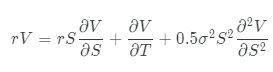

 - 방정식에 대한 해
 
     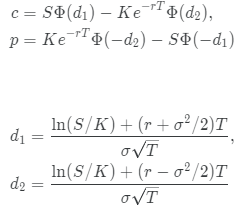

     * S는 0시점의 주식(혹은 기초자산)의 가격
     * Φ(x)는 표준정규분포의 누적 분포 함수
     * K는 행사가격
     * r은 무위험 이자율
     * T는 옵션만기까지 남은 기간
     * σ는 주가의 변동성

**예를 들어, 현재 주가(S) 42, 행사 가격(K) 40, 무위험이자율(r) 연 10%, 주가변동의 표준편차(**σ**) 20%, 만기까지 남은 기간 6개월(T)인 경우에 유럽형 옵션의 기본가격을 구해보자**

 - d1 = [ln(42/40) + (0.1+0.5×0.2^2)*0.5]/(0.2 × 0.5^0.5) = 0.7693

 - d2 = [ln(42/40) + (0.1-0.5×0.2^2)*0.5]/(0.2 × 0.5^0.5) = 0.6278

 - N(0.7693) = 0.7791 // N(0.6278) = 0.7349 // N(-0.7693) = 0.2209 // N(-0.6278) = 0.2651

 - 콜옵션 C = 42 × 0.7791 - 40 × e^(-0.1×0.5) × 0.7349 = 4.76

 - 풋옵션 p = 4.76 - 42 + 40 × e^(-0.1×0.5) = 0.81

   → **여기서 콜옵션 4.76 중에서 내재가치는 2 (주가 - 행사가격) 그리고 시간가치 2.76으로 구성되어 있고, 풋옵션 가격 0.81은 모두 시간가치이다**

In [ ]:
import numpy as np
from scipy.stats import norm


def simulate_gbm(s_0, mu, sigma, n_sims, T, N, random_seed=42, antithetic_var=False):
    '''
    Function used for simulating stock returns using Geometric Brownian Motion.
    
    Parameters
    ----------
    s_0 : float
        Initial stock price
    mu : float
        Drift coefficient
    sigma : float
        Diffusion coefficient
    n_sims : int
        Number of simulations paths
    dt : float
        Time increment, most commonly a day
    T : float
        Length of the forecast horizon, same unit as dt
    N : int
        Number of time increments in the forecast horizon
    random_seed : int
        Random seed for reproducibility
    antithetic_var : bool
        Boolean whether to use antithetic variates approach to reduce variance
    Returns
    -------
    S_t : np.ndarray
        Matrix (size: n_sims x (T+1)) containing the simulation results. 
        Rows respresent sample paths, while columns point of time.
    '''

    np.random.seed(random_seed)

    # time increment
    dt = T/N

    # Brownian
    if antithetic_var:
        dW_ant = np.random.normal(scale=np.sqrt(dt),
                                  size=(int(n_sims/2), N + 1))
        dW = np.concatenate((dW_ant, -dW_ant), axis=0)
    else:
        dW = np.random.normal(scale=np.sqrt(dt),
                              size=(n_sims, N + 1))

    # simulate the evolution of the process
    S_t = s_0 * np.exp(np.cumsum((mu - 0.5 * sigma ** 2) * dt + sigma * dW,
                                 axis=1))
    S_t[:, 0] = s_0

    return S_t

def black_scholes_analytical(S_0, K, T, r, sigma, type='call'):
    '''
    Function used for calculating the price of European options using the analytical form of the Black-Scholes model.
    
    Parameters
    ------------
    s_0 : float
        Initial stock price
    K : float
        Strike price
    T : float
        Time to maturity in years
    r : float
        Annualized risk-free rate
    sigma : float
        Standard deviation of the stock returns
    
    Returns
    -----------
    option_premium : float
        The premium on the option calculated using the Black-Scholes model
    '''

    d1 = (np.log(S_0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S_0 / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))

    if type == 'call':
        option_premium = (S_0 * norm.cdf(d1, 0, 1) - K * np.exp(-r * T) * norm.cdf(d2, 0, 1))
    elif type == 'put':
        option_premium = (K * np.exp(-r * T) * norm.cdf(-d2, 0, 1) - S_0 * norm.cdf(-d1, 0, 1))
    else:
        raise ValueError('Wrong input for type!')

    return option_premium


def lsmc_american_option(S_0, K, T, N, r, sigma, n_sims, option_type, poly_degree, random_seed=42):
    '''
    Function used for calculating the price of American options using Least Squares Monte Carlo 
    algorithm of Longstaff and Schwartz (2001).
    
    Parameters
    ------------
    S_0 : float
        Initial stock price
    K : float
        Strike price
    T : float
        Time to maturity in years
    N : int
        Number of time increments in the forecast horizon
    r : float
        Annualized risk-free rate
    sigma : float
        Standard deviation of the stock returns
    n_sims : int
        Number of paths to simulate
    option_type : str
        Type of the option. Allowable: ['call', 'put']
    poly_degree : int
        Degree of the polynomial to fit in the LSMC algorithm
    random_seed : int
        Random seed for reproducibility
        
    Returns
    -----------
    option_premium : float
        The premium on the option 
    '''

    dt = T / N
    discount_factor = np.exp(-r * dt)

    gbm_simulations = simulate_gbm(s_0=S_0, mu=r, sigma=sigma, 
                                   n_sims=n_sims, T=T, N=N,
                                   random_seed=random_seed)

    if option_type == 'call':
        payoff_matrix = np.maximum(
            gbm_simulations - K, np.zeros_like(gbm_simulations))
    elif option_type == 'put':
        payoff_matrix = np.maximum(
            K - gbm_simulations, np.zeros_like(gbm_simulations))

    value_matrix = np.zeros_like(payoff_matrix)
    value_matrix[:, -1] = payoff_matrix[:, -1]

    for t in range(N - 1, 0, -1):
        regression = np.polyfit(
            gbm_simulations[:, t], value_matrix[:, t + 1] * discount_factor, poly_degree)
        continuation_value = np.polyval(regression, gbm_simulations[:, t])
        value_matrix[:, t] = np.where(payoff_matrix[:, t] > continuation_value,
                                      payoff_matrix[:, t],
                                      value_matrix[:, t + 1] * discount_factor)

    option_premium = np.mean(value_matrix[:, 1] * discount_factor)
    return option_premium

In [ ]:
import numpy as np
from scipy.stats import norm

In [ ]:
#매개변수 정의

S_0 = 100 #최초 주가
K = 100 #스트라이크 가격, 옵션 행사가격
r = 0.05 #연간 무위험 금리
sigma = 0.50 #기초 주식 변동성(연간 표준편차)
T = 1 # 1 year #만기 때까지 시간
N = 252 # 252 days in a year
dt = T / N # time step
N_SIMS = 1000000 # number of simulations 
discount_factor = np.exp(-r * T) #할인 요인, 미래 수익의 현재 가치 계산

In [ ]:
#블랙숄즈 모델의 닫힌 해를 사용해 옵션 프리미엄을 계산하는 함수

def black_scholes_analytical(S_0, K, T, r, sigma, type='call'):
    '''
    Function used for calculating the price of European options using the analytical form of the Black-Scholes model.
    
    Parameters
    ------------
    s_0 : float
        Initial stock price
    K : float
        Strike price
    T : float
        Time to maturity in years
    r : float
        Annualized risk-free rate
    sigma : float
        Standard deviation of the stock returns
    type : str
        Type of the option. Allowable: ['call', 'put']
    
    Returns
    -----------
    option_premium : float
        The premium on the option calculated using the Black-Scholes model
    '''
    
    d1 = (np.log(S_0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S_0 / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    if type == 'call':
        val = (S_0 * norm.cdf(d1, 0, 1) - K * np.exp(-r * T) * norm.cdf(d2, 0, 1))
    elif type == 'put':
        val = (K * np.exp(-r * T) * norm.cdf(-d2, 0, 1) - S_0 * norm.cdf(-d1, 0, 1))
    else:
        raise ValueError('Wrong input for type!')
        
    return val

In [ ]:
#설정된 매개 변수를 사용하여 콜 옵션 평가
black_scholes_analytical(S_0=S_0, K=K, T=T, r=r, sigma=sigma, type='call')

21.79260421286685

In [ ]:
#주식 경로 시뮬레이션 (사전에 정의한 함수)

gbm_sims = simulate_gbm(s_0=S_0, mu=r, sigma=sigma, 
                       n_sims=N_SIMS, T=T, N=N)

In [ ]:
#옵션 프리미엄 계산
premium = discount_factor * np.mean(np.maximum(0, gbm_sims[:, -1] - K))
premium

21.756178586245806

<**추가사항**>
**최종 주가에만 관심을 가지고 있는 옵션의 특성상, 시간 T에서의 가격만 시뮬레이션하고 예상 수익을 계산해보자** 

In [ ]:
black_scholes_analytical(S_0=S_0, K=K, T=T, r=r, sigma=sigma, type='put')

16.915546662938254

In [ ]:
def european_option_simulation(S_0, K, T, r, sigma, n_sims, type='call', random_seed=42):
    '''
    Function used for calculating the price of European options using Monte Carlo simulations.
    
    Parameters
    ------------
    S_0 : float
        Initial stock price
    K : float
        Strike price
    T : float
        Time to maturity in years
    r : float
        Annualized risk-free rate
    sigma : float
        Standard deviation of the stock returns
    n_sims : int
        Number of paths to simulate
    type : str
        Type of the option. Allowable: ['call', 'put']
    random_seed : int
        Random seed for reproducibility
        
    Returns
    -----------
    option_premium : float
        The premium on the option calculated using Monte Carlo simulations
    '''
    np.random.seed(random_seed)
    rv = np.random.normal(0, 1, size=n_sims)
    S_T = S_0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * rv)

    if type == 'call':
        payoff = np.maximum(0, S_T - K)
    elif type == 'put':
        payoff = np.maximum(0, K - S_T)
    else: 
        raise ValueError('Wrong input for type!')
    #여기까지 기하 브라운 모형을 이용한 t시점의 주가 산출
        
    premium = np.mean(payoff) * np.exp(-r * T) #산출한 주가에 대한 현가 할인
    return premium

In [ ]:
european_option_simulation(S_0, K, T, r, sigma, N_SIMS, type='put')

16.948225203893127

# 3. 최소 자승 몬테카를로를 사용해 미국 옵션 가격 결정

1. 유럽 옵션 vs 미국 옵션
 - 미국 옵션 : 만기 이전에 언제든지 옵션 행사를 할 수 있다 (유럽 옵션은 만기에서만 가능)

    → 닫힌 해가 없다. 중간에 옵션 행사를 할 수 있어서, 샘플 경로의 최종값만 보는 것은 의미가 없다

    → 최소 자승 몬테카를로를 사용해보자


2. 최소 자승 몬테카를로
 - 옵션 중간 행사 : 임의의 시간(t) 시점에서 즉시 행사 시 수익이 유지 가치보다 큰 경우에 조기 행사
 - 즉, Vt(s) = max(ht(s), Ct(s))
 
    [ht(s) : 옵션 행사 수익, Ct(s) : 옵션의 유지 가격(행사하지 않을 경우 예상되는 수익)]
 - Ct(s) = Et^q × [e^(-rdt) × Vt+dt(St+dt) |St=s] 

    [r : 무위험 금리, dt : 시간 증가분, Et^q : 주어진 기초 가격에 대한 위험-중립 기대값]
 - Vt+dt(St+dt)를 x차 시간 회귀를 사용해서 추정한다. 그리고 e^(-rdt)로 현재가로 할인한다.

In [ ]:
#매개변수 정의
S_0 = 36
K = 40
r = 0.06
sigma = 0.2
T = 1 # 1 year
N = 50 
dt = T / N 
N_SIMS = 10 ** 5 
discount_factor = np.exp(-r * dt)
OPTION_TYPE = 'put'
POLY_DEGREE = 5 

In [ ]:
#GBM을 사용해 주가 시뮬레이션
gbm_sims = simulate_gbm(s_0=S_0, mu=r, sigma=sigma, n_sims=N_SIMS, 
                        T=T, N=N)

In [ ]:
#수익행렬 계산 : 유럽 옵션 식 사용
payoff_matrix = np.maximum(K - gbm_sims, np.zeros_like(gbm_sims))

In [ ]:
#가치 행렬을 정의하고 마지막 열을 채운다. 마지막 열은 끝 값이므로 유럽 옵션 결과값으로 채우면 된다
value_matrix = np.zeros_like(payoff_matrix)
value_matrix[:, -1] = payoff_matrix[:, -1]

In [ ]:
#주어진 시간에 대한 가치 벡터와 유지가치를 반복적으로 계산한다 (5차 다항식을 사용한 회귀 시행)
for t in range(N - 1, 0 , -1):
    regression = np.polyfit(gbm_sims[:, t], 
                            value_matrix[:, t + 1] * discount_factor, 
                            POLY_DEGREE)
    continuation_value = np.polyval(regression, gbm_sims[:, t])
    value_matrix[:, t] = np.where(
        payoff_matrix[:, t] > continuation_value,
        payoff_matrix[:, t],
        value_matrix[:, t + 1] * discount_factor #수익이 유지 기대값보다 높으면 그 값을 수익으로 설정. 그리고 할인시킨다
    )

In [ ]:
#옵션 프리미엄을 계산한다 #T=1 값 벡터의 평균값을 취해 옵션 프리미엄을 얻었다
option_premium = np.mean(value_matrix[:, 1] * discount_factor)
print(f'The premium on the specified American {OPTION_TYPE} option is {option_premium:.3f}')

The premium on the specified American put option is 4.465


In [ ]:
#유럽 풋 옵션 프리미엄도 계산해본다
black_scholes_analytical(S_0=S_0, K=K, T=T, r=r, sigma=sigma, 
                         type='put')

3.84430779159684

In [ ]:
#미국, 유럽 콜 옵션 가격 계산해본다
european_call_price = black_scholes_analytical(S_0=S_0, K=K, T=T, 
                                               r=r, sigma=sigma)
american_call_price = lsmc_american_option(S_0=S_0, K=K, T=T, N=N, r=r, 
                                           sigma=sigma, n_sims=N_SIMS, 
                                           option_type='call', 
                                           poly_degree=POLY_DEGREE)
print(f"The price of the European call is {european_call_price:.3f}, and the American call's price (using {N_SIMS} simulations) is {american_call_price:.3f}")

The price of the European call is 2.174, and the American call's price (using 100000 simulations) is 2.097


# 4. Quantlib를 사용한 미국 옵션 가격 결정

In [ ]:
!pip install Quantlib

     |████████████████████████████████| 17.9 MB 219 kB/s 


In [ ]:
import QuantLib as ql

In [ ]:
S_0 = 36
r = 0.06
sigma = 0.2
K = 40
OPTION_TYPE = 'put'
POLY_DEGREE = 5 
R_SEED = 42
N_SIMS = 10 ** 5 
N = 50 

In [ ]:
#달력과 일자 계산 기준을 설정
#일 계산 규칙에 따라 채권과 같은 다양한 금융상품에 대한 이자발생 방식이 결정
calendar = ql.UnitedStates()
day_counter = ql.ActualActual() #실제 경과 시간과 실제 1년의 365일 일수 사용. 360일을 사용할 수도 있다

In [ ]:
#옵션의 평가일과 만기일 설정
valuation_date = ql.Date(1, 1, 2018) #평가일
expiry_date =  ql.Date(1, 1, 2019) #만기일
ql.Settings.instance().evaluationDate = valuation_date

In [ ]:
#옵션 형식(콜/풋)과 행사 유형(미쿡), 수익(바닐라)을 정의한다
#바닐라 : 보유자에게 기초자산을 사전에 설정한 가격으로 특정한 기간 내에 사거나 팔 권리를 제공하지만, 의무는 지우지 않는다. 이외에는 이색 옵션이 있다
if OPTION_TYPE == 'call':
    option_type_ql = ql.Option.Call
elif OPTION_TYPE == 'put':
    option_type_ql = ql.Option.Put
        
exercise = ql.AmericanExercise(valuation_date, expiry_date)
payoff = ql.PlainVanillaPayoff(option_type_ql, K)

In [ ]:
#시장 관련 데이터를 준비한다
u = ql.SimpleQuote(S_0)
r = ql.SimpleQuote(r)
sigma = ql.SimpleQuote(sigma)

In [ ]:
#시장 관련 곡선을 설정한다
# volatility = ql.BlackConstantVol(valuation_date, calendar, sigma, day_counter) 변동성
# risk_free_rate = ql.FlatForward(valuation_date, r, day_counter) 무위험 금리
underlying = ql.QuoteHandle(u) #기초 상품에 대한 가격
volatility = ql.BlackConstantVol(0, ql.TARGET(), 
                                 ql.QuoteHandle(sigma), 
                                 day_counter)
risk_free_rate = ql.FlatForward(0, ql.TARGET(), 
                                ql.QuoteHandle(r), 
                                day_counter)

In [ ]:
#시장 관련 데이터를 블랙-숄츠 프로세스에 전달한다
bs_process = ql.BlackScholesProcess(
    underlying,
    ql.YieldTermStructureHandle(risk_free_rate),
    ql.BlackVolTermStructureHandle(volatility),
)

In [ ]:
#미국 옵션에 대한 몬테카를로 엔진을 인스턴스화한다 #원하는 시뮬레이션 수, 이산화 시간 단계수, 다항식 차수 등
engine = ql.MCAmericanEngine(bs_process, 'PseudoRandom', timeSteps=N, 
                             polynomOrder=POLY_DEGREE, 
                             seedCalibration=R_SEED, 
                             requiredSamples=N_SIMS)

In [ ]:
#option 객체를 인스턴스화하고 가격 책정 엔진을 설정한다
option = ql.VanillaOption(payoff, exercise)
option.setPricingEngine(engine)

In [ ]:
#옵션 프리미엄을 계산한다
option_premium_ql = option.NPV()
print(f'The value of the American {OPTION_TYPE} option is: {option_premium_ql:.3f}')

The value of the American put option is: 4.459


In [ ]:
u_0 = u.value() # original value
h = 0.01

u.setValue(u_0 + h)
P_plus_h = option.NPV()

u.setValue(u_0 - h)
P_minus_h = option.NPV()

u.setValue(u_0) # set back to the original value

delta = (P_plus_h - P_minus_h) / (2 * h)

print(f'Delta of the option: {delta:.2f}')

Delta of the option: -0.51


# 5. 몬테카를로를 사용해 VAR 추정

1. VAR : 정상적인 시장 조건 하에서 특정 기간 동안 최악의 예상 손실
 - 예를 들어 포트폴리오의 1일 95% VaR이 100달러라면, 95%의 시간 동안은 100달러 이상이 손실을 보지 않는다라는 뜻
 - VaR을 추정하는 방법 : 모수적 기법(분산-공분산), 과거 시뮬레이션(추정), 몬테카를로 시뮬레이션

2. VaR을 계산하는 두가지 방법
 - 가격에서 VaR 계산 : 주식 수와 자산 가격을 사용해 현재 포트폴리오 가치와 X일 이후의 가능 가치를 계산한다
 - 수익률에서 VaR 계산 : 포트폴리오 각 자산의 백분율 가중치와 자산의 기대 수익률을 사용해 X일 이후 예상 포트폴리오 수익률을 계산할 수 있다. 그런 다음 수익률과 현재 포트폴리오 값을 기준으로 VaR을 달러 금액으로 표시한다

페북과 구글만 가지고 있다고 생각하고 하루동안의 VaR을 추정해보자

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns

In [ ]:
# set random seed for reproducibility
np.random.seed(42)

In [ ]:
RISKY_ASSETS = ['GOOG', 'FB']
SHARES = [5, 5]
START_DATE = '2018-01-01'
END_DATE = '2018-12-31'
T = 1
N_SIMS = 10 ** 5

In [ ]:
df = yf.download(RISKY_ASSETS, start=START_DATE, 
                 end=END_DATE, adjusted=True)
print(f'Downloaded {df.shape[0]} rows of data.')

[*********************100%***********************]  2 of 2 completed
Downloaded 250 rows of data.


In [ ]:
df.head()

Adj Close                    Close                     High  \
                    FB         GOOG          FB         GOOG          FB   
Date                                                                       
2018-01-02  181.419998  1065.000000  181.419998  1065.000000  181.580002   
2018-01-03  184.669998  1082.479980  184.669998  1082.479980  184.779999   
2018-01-04  184.330002  1086.400024  184.330002  1086.400024  186.210007   
2018-01-05  186.850006  1102.229980  186.850006  1102.229980  186.899994   
2018-01-08  188.279999  1106.939941  188.279999  1106.939941  188.899994   

                                Low                     Open               \
                   GOOG          FB         GOOG          FB         GOOG   
Date                                                                        
2018-01-02  1066.939941  177.550003  1045.229980  177.679993  1048.339966   
2018-01-03  1086.290039  181.330002  1063.209961  181.880005  1064.310059   
2018-01-04  1093.569946  184.100006  1084.001953  184.899994  1088.000000   
2018-01-05  1104.250000  184.929993  1092.000000  185.589996  1094.000000   
2018-01-08  1111.270020  186.330002  1101.619995  187.199997  1102.229980   

              Volume           
                  FB     GOOG  
Date                           
2018-01-02  18151900  1237600  
2018-01-03  16886600  1430200  
2018-01-04  13880900  1004600  
2018-01-05  13574500  1279100  
2018-01-08  17994700  1047600

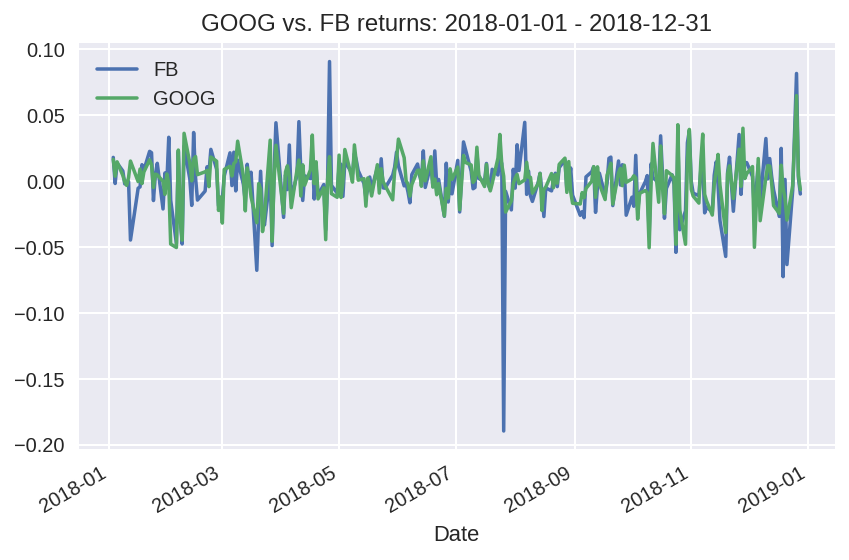

Correlation between returns: 0.62


In [ ]:
adj_close = df['Adj Close']
returns = adj_close.pct_change().dropna()
plot_title = f'{" vs. ".join(RISKY_ASSETS)} returns: {START_DATE} - {END_DATE}'
returns.plot(title=plot_title)

plt.tight_layout()

plt.show()
#수익률 간의 상관관계도 보여주기
print(f'Correlation between returns: {returns.corr().values[0,1]:.2f}')

In [ ]:
#공분산 행렬 계산
cov_mat = returns.cov()
cov_mat

,FB,GOOG
FB,0.000575,0.000265
GOOG,0.000265,0.000315


In [ ]:
#공분산 행렬의 촐레스키 분해 수행
chol_mat = np.linalg.cholesky(cov_mat)
chol_mat

array([[0.02397822, 0.        ],
       [0.01105641, 0.01389752]])

In [ ]:
#표준 정규 부노로부터 상관된 랜덤 수를 추출한다
rv = np.random.normal(size=(N_SIMS, len(RISKY_ASSETS)))
correlated_rv = np.transpose(np.matmul(chol_mat, np.transpose(rv)))

In [ ]:
#시뮬레이션에 사용될 측도를 정의한다
r = np.mean(returns, axis=0).values
sigma = np.std(returns, axis=0).values
S_0 = adj_close.values[-1, :]
P_0 = np.sum(SHARES * S_0)

In [ ]:
#고려한 주식의 최종가격을 계산한다
S_T = S_0 * np.exp((r - 0.5 * sigma ** 2) * T + 
                   sigma * np.sqrt(T) * correlated_rv)

In [ ]:
#최종 포트폴리오 가치와 포트폴리오 수익률을 계산한다
P_T = np.sum(SHARES * S_T, axis=1)
P_diff = P_T - P_0

In [ ]:
#선택된 신뢰 수준의 VaR을 계산한다
P_diff_sorted = np.sort(P_diff)
percentiles = [0.01, 0.1, 1.]
var = np.percentile(P_diff_sorted, percentiles)

for x, y in zip(percentiles, var):
    print(f'1-day VaR with {100-x}% confidence: {-y:.2f}$')

1-day VaR with 99.99% confidence: 8.24$
1-day VaR with 99.9% confidence: 7.14$
1-day VaR with 99.0% confidence: 5.78$


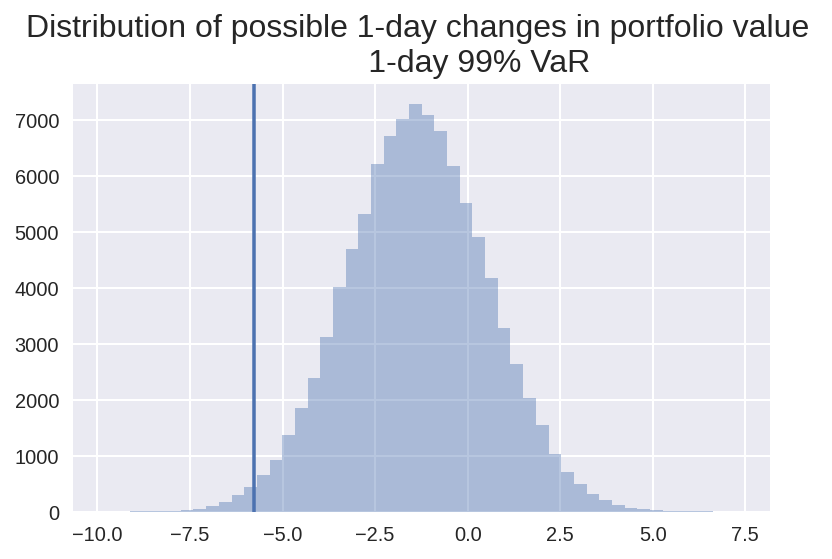

In [ ]:
#그래프
ax = sns.distplot(P_diff, kde=False)
ax.set_title('''Distribution of possible 1-day changes in portfolio value 
             1-day 99% VaR''', fontsize=16)
ax.axvline(var[2], 0, 10000)

plt.tight_layout()

plt.show()

In [ ]:
var = np.percentile(P_diff_sorted, 5)
expected_shortfall = P_diff_sorted[P_diff_sorted<=var].mean()

print(f'The 1-day 95% VaR is {-var:.2f}$, and the accompanying Expected Shortfall is {-expected_shortfall:.2f}$.')

The 1-day 95% VaR is 4.48$, and the accompanying Expected Shortfall is 5.27$.
